In [1]:
%load_ext autoreload
%autoreload 2
import os 
os.environ["HF_HOME"] = "/tmp/wendler/hf_cache"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
sys.path.append('/share/u/wendler/code/my-sdxl-unbox')

In [2]:
n = 30
path_to_checkpoints = '../hparam_study/'#'../checkpoints/'#'../hparam_study/'
k = 160
exp = 4
n_timesteps = 20
use_vanilla = True
dtype="fp16"
batch_size = 16

In [3]:
outfile = f"timestep_generalization_n{n}_t{n_timesteps}_{'vanilla' if use_vanilla else 'turbo'}_k{k}_exp{exp}.csv"

In [4]:
n_feats = exp * 1280

In [ ]:
import os
import gradio as gr
import torch
from SDLens import HookedStableDiffusionXLPipeline
from SAE import SparseAutoencoder
from app import create_demo
assert torch.cuda.is_available(), "Your machine has no access to GPU. If you are using Colab, consider changing environment"
# The SAEs were trained to work with torch.float32, but they can also work with torch.float16
# Change this value to torch.float32 if you have access to a GPU with >30GB of memory
if dtype == "fp32":
    dtype = torch.float32
else:
    dtype = torch.float16

sdxl_turbo = "stabilityai/sdxl-turbo" 
sdxl = "stabilityai/stable-diffusion-xl-base-1.0"
if not use_vanilla:
    model_name = sdxl_turbo 
else:
    model_name = sdxl

pipe = HookedStableDiffusionXLPipeline.from_pretrained(
    model_name,
    torch_dtype=dtype,
    device_map="balanced",
    variant=("fp16" if dtype==torch.float16 else None)
)
pipe.set_progress_bar_config(disable=True)

In [ ]:
model_name

'stabilityai/stable-diffusion-xl-base-1.0'

In [7]:
code_to_block = {
    "down.2.1": "unet.down_blocks.2.attentions.1",
    "mid.0": "unet.mid_block.attentions.0",
    "up.0.1": "unet.up_blocks.0.attentions.1",
    "up.0.0": "unet.up_blocks.0.attentions.0"
}

saes_dict = {}
means_dict = {}

for code, block in code_to_block.items():
    sae = SparseAutoencoder.load_from_disk(
        os.path.join(path_to_checkpoints, f"{block}_k{k}_hidden{n_feats}_auxk256_bs4096_lr0.0001", "final"),
    )
    saes_dict[code] = sae.to('cuda', dtype=dtype)

In [8]:
import numpy as np
from matplotlib import pyplot as plt
import json
if n > 5:
    with open('/tmp/wendler/first_50K_prompts.json', 'r') as f:
        prompts = json.load(f)
    prompts = [p["caption"] for p in prompts[n:2*n]]
else:
    prompts = [
        "A photo of a cat",
        "A photo of a dog",
        "A photo of a bird",
        "A photo of a fish",
        "A photo of a horse",
    ]

In [ ]:
prompts

['Two baseball players high fiving each other.',
 'An orange helmet with a blue button on it.',
 'The model in this burgundy gown is posing.',
 'an old brick wall with some white paint',
 'White Converse sneakers with star detail on the side.',
 'A group of men standing at the bar in front of a wine glass.',
 'The living room has an ocean view and wooden floors.',
 'A man and woman holding up their baby in the air.',
 'The model wears black skinny jeans and heels.',
 'Four pictures show the interior and bedroom on a cruise ship.',
 'The words thank you are surrounded by leaves.',
 'Two children waving from the back of an old car.',
 'The woman is dressed in blue and white.',
 'A man wearing a multicolored sweater.',
 'The runway shows a woman in brown pants and jacket.',
 'Pink wallet case with matching stand and card holder.',
 'An Apple computer monitor sitting on top of a white desk.',
 'a yellow house with red shutters and plants',
 'The vineyard is growing very well in the field.'

In [10]:
# find out the models inside of pipe
if dtype == torch.float32:
    pipe.text_encoder.to(dtype=torch.float32)
    pipe.text_encoder_2.to(dtype=torch.float32)

In [11]:
from collections import defaultdict
for short, sae in saes_dict.items():
    print(short, sae.path)

down.2.1 ../hparam_study/unet.down_blocks.2.attentions.1_k160_hidden5120_auxk256_bs4096_lr0.0001/final
mid.0 ../hparam_study/unet.mid_block.attentions.0_k160_hidden5120_auxk256_bs4096_lr0.0001/final
up.0.1 ../hparam_study/unet.up_blocks.0.attentions.1_k160_hidden5120_auxk256_bs4096_lr0.0001/final
up.0.0 ../hparam_study/unet.up_blocks.0.attentions.0_k160_hidden5120_auxk256_bs4096_lr0.0001/final


In [12]:
sys.path.append('/share/u/wendler/code/my-sdxl-unbox/scripts')
with torch.no_grad():
    from train_sae import explained_variance
    from tqdm import tqdm
    from einops import einsum, rearrange
    verbose = False
    results = defaultdict(list)
    guidance_scale = 0.0 if not use_vanilla else 7.5
    # make a dataloader
    from torch.utils.data import DataLoader
    dataloader = DataLoader(prompts, batch_size=batch_size, shuffle=False)
    for pidx, batch in enumerate(tqdm(dataloader)):
        output, cache = pipe.run_with_cache(
            batch,
            positions_to_cache=list(code_to_block.values()),
            save_input=True,
            save_output=True,
            num_inference_steps=n_timesteps,
            guidance_scale=guidance_scale,
            generator=torch.Generator(device="cpu").manual_seed(42),
            output_type="latent"
        )
        timesteps = pipe.scheduler.timesteps
        if verbose:
            plt.imshow(output.images[0])
            plt.show()
        #for short, long in code_to_block.items():
        for short, sae in saes_dict.items():
            long = code_to_block[short]
            diff = cache['output'][long] - cache['input'][long]
            if diff.shape[0] == 2*batch_size:
                diff_uncond, diff_cond = diff.chunk(2)
                diffs = [diff_uncond, diff_cond]
            else:
                diffs = [diff]
            for cfg_idx, diff in enumerate(diffs):
                # timesteps x features x height x width
                assert long in sae.path, f"long {long} not in sae.path {sae.path}"
                sae.eval()
                diff_perm = rearrange(diff, "b t f h w -> b t h w f")
                # timesteps x height x width x features
                features = sae.encode(diff_perm)                
                # timesteps x height x width x features
                recon_perm = features @ sae.decoder.weight.T + sae.pre_bias
                # they should be similar
                fnormalized = features / features.norm(dim=-1, keepdim=True)
                dnormalized = diff_perm / diff_perm.norm(dim=-1, keepdim=True)
                fnormalized = features / features.norm(dim=-1, keepdim=True)
                dnormalized = diff_perm / diff_perm.norm(dim=-1, keepdim=True)
                fbinarized = (features > 0).float()
                fdots = einsum(fnormalized[:, :-1], fnormalized[:, 1:], "b t h w f, b t h w f -> b t h w").mean(dim=0).mean(dim=1).mean(dim=1)
                dots = einsum(dnormalized[:, :-1], dnormalized[:, 1:], "b t h w f, b t h w f -> b t h w").mean(dim=0).mean(dim=1).mean(dim=1)
                fdots_binarized = einsum(fbinarized[:, :-1], fbinarized[:, 1:], "b t h w f, b t h w f -> b t h w") # == intersection 
                
                # union next
                fdots_union = (fbinarized[:, :-1] + fbinarized[:, 1:]).clamp(0, 1).sum(dim=-1)
                iou = fdots_binarized / fdots_union
                iou_mean = iou.mean(dim=0).mean(dim=1).mean(dim=1)
                # timesteps x (height * width) x features
                for idx in range(diff.shape[1]):
                    diff_flat = rearrange(diff_perm[:, idx], "b h w f-> (b h w) f")
                    recon_flat = rearrange(recon_perm[:, idx], "b h w f-> (b h w) f")
                    # expects n x features
                    explained_var = explained_variance(diff_flat, recon_flat)
                    if cfg_idx == 0:
                        results["block"].append(short)
                        results["tidx"].append(idx)
                        results["t"].append(timesteps[idx].item())
                    results[f"explained_var_{cfg_idx}"].append(explained_var.item())
                    
                    if idx == diff.shape[1] - 1:
                        results[f"fdots_{cfg_idx}"].append(0.0)
                        results[f"dots_{cfg_idx}"].append(0.0)
                        results[f"iou_{cfg_idx}"].append(0.0)
                    else:
                        results[f"fdots_{cfg_idx}"].append(fdots[idx].item())
                        results[f"dots_{cfg_idx}"].append(dots[idx].item())
                        results[f"iou_{cfg_idx}"].append(iou_mean[idx].item())
                    
    from pandas import DataFrame
    df = DataFrame(results)
    df.to_csv(outfile)
    df

100%|██████████| 3/3 [00:11<00:00,  3.90s/it]


In [13]:
df.groupby(["block", "tidx"]).mean().reset_index()

,block,tidx,t,explained_var_0,fdots_0,dots_0,iou_0,explained_var_1,fdots_1,dots_1,iou_1
0,down.2.1,0,501.0,0.646973,0.706706,0.603353,0.335755,0.626302,0.704264,0.603841,0.338061
1,down.2.1,1,1.0,0.574219,0.000000,0.000000,0.000000,0.568522,0.000000,0.000000,0.000000
2,mid.0,0,501.0,0.699219,0.410319,0.397949,0.158301,0.698730,0.411621,0.401693,0.158727
3,mid.0,1,1.0,0.603516,0.000000,0.000000,0.000000,0.603516,0.000000,0.000000,0.000000
4,up.0.0,0,501.0,0.795898,0.539062,0.551921,0.246394,0.783040,0.535482,0.551432,0.246621
5,up.0.0,1,1.0,0.672038,0.000000,0.000000,0.000000,0.665853,0.000000,0.000000,0.000000
6,up.0.1,0,501.0,0.737793,0.508464,0.373047,0.217650,0.730469,0.510905,0.381755,0.218526
7,up.0.1,1,1.0,0.573405,0.000000,0.000000,0.000000,0.576497,0.000000,0.000000,0.000000


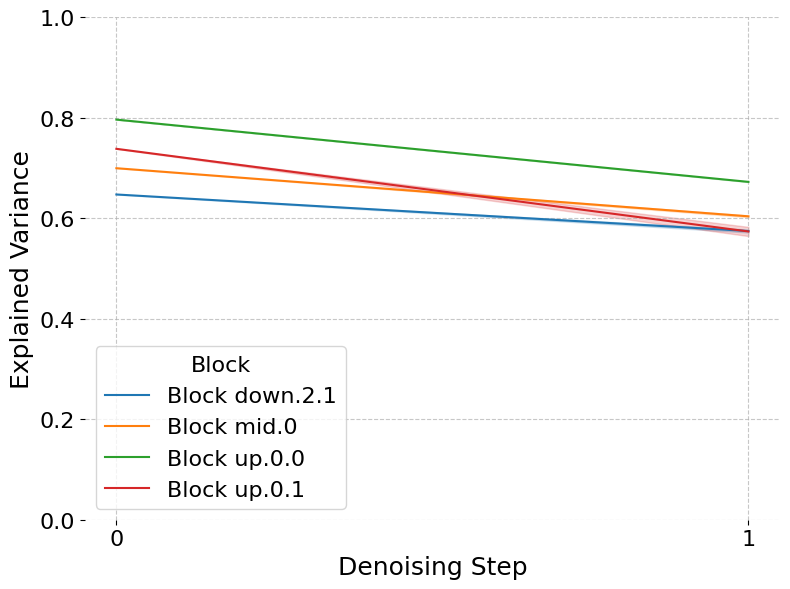

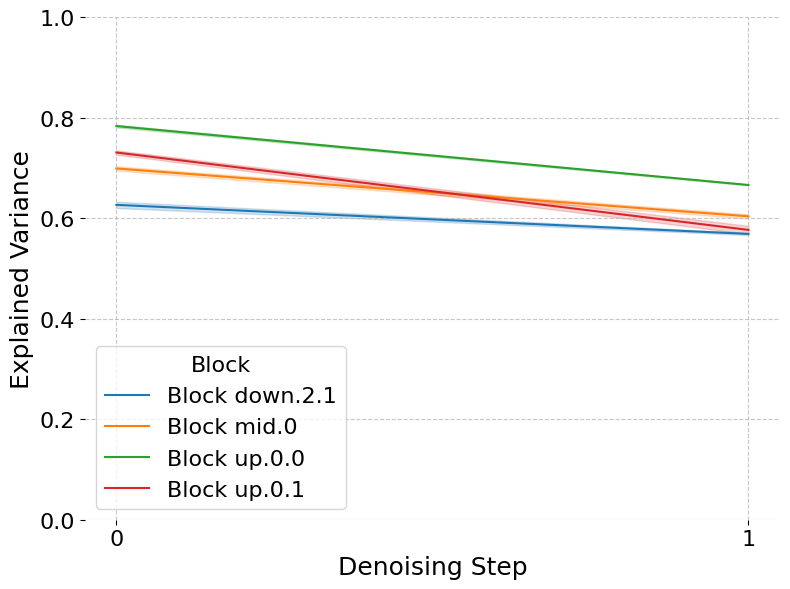

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the number of cfg indices
cfg_indices = []
if use_vanilla:
    cfg_indices = [0, 1]  # Only get cfg indices when use_vanilla is true
else:
    cfg_indices = [0]

# Create a separate figure for each cfg_idx
for cfg_idx in cfg_indices:
    # Create a new figure for each cfg_idx
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    
    # Group by block and tidx to get mean and std of explained variance for this cfg_idx
    var_col = f"explained_var_{cfg_idx}"
    summary_df = df.groupby(["block", "tidx"])[var_col].agg(['mean', 'std']).reset_index()
    
    # Remove border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    blocks = summary_df['block'].unique()
    colors = sns.color_palette(n_colors=len(blocks))
    
    for i, block in enumerate(blocks):
        block_df = summary_df[summary_df['block'] == block]
        ax.plot(block_df['tidx'], block_df['mean'], label=f"Block {block}", color=colors[i])
        # Gaussian confidence interval: mean ± 1.96*std
        lower = block_df['mean'] - 1.96 * block_df['std']/np.sqrt(len(block_df))
        upper = block_df['mean'] + 1.96 * block_df['std']/np.sqrt(len(block_df))
        ax.fill_between(block_df['tidx'], lower, upper, color=colors[i], alpha=0.2)
    
    # Add gridlines
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Increase font size
    ax.set_xlabel("Denoising Step", fontsize=18)
    ax.set_ylabel("Explained Variance", fontsize=18)
    ax.legend(title="Block", loc='lower left', fontsize=16, title_fontsize=16)
    # they should be just 1 apart
    ax.set_xticks(block_df['tidx'])
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.savefig(f"{outfile.replace('.csv', '')}_explained_variance_cfg_{cfg_idx}.pdf")
    plt.savefig(f"{outfile.replace('.csv', '')}_explained_variance_cfg_{cfg_idx}.png")
    plt.show()

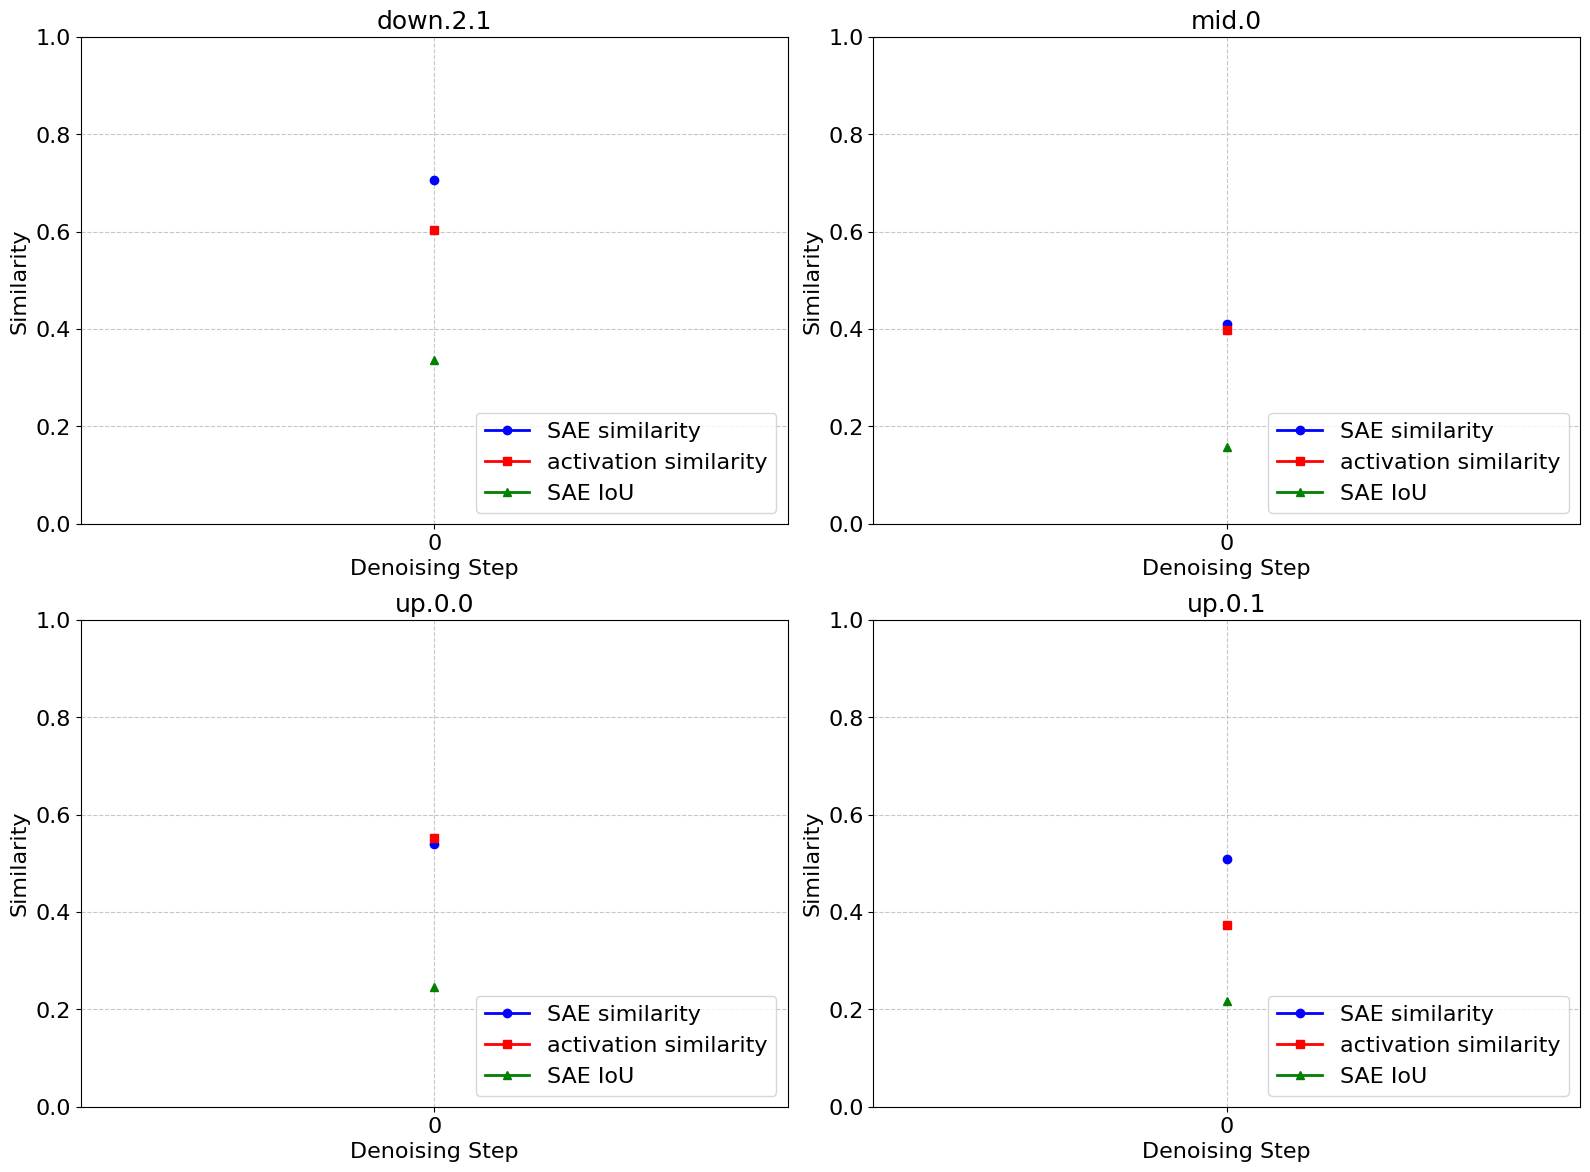

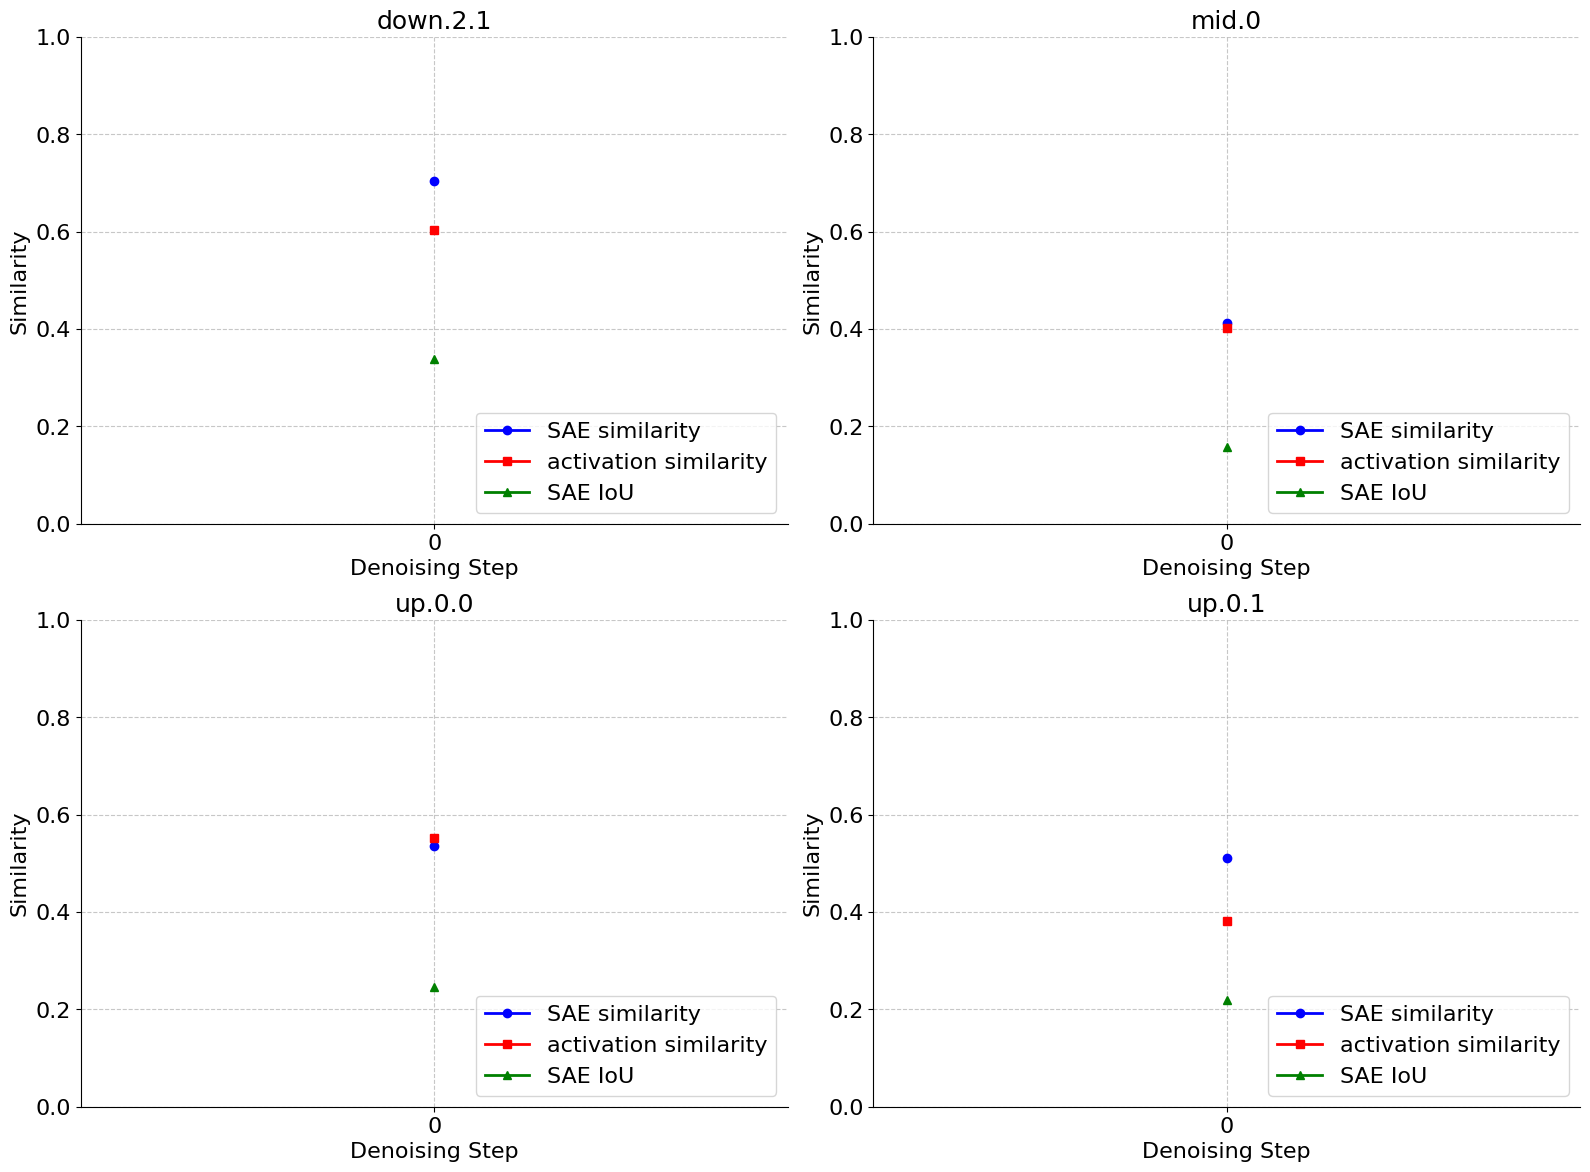

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get unique block names
block_types = sorted(df['block'].unique())

# Get the number of cfg indices
if use_vanilla:
    cfg_indices = [0, 1]  # Assuming we have cfg_idx 0 and 1
else:
    cfg_indices = [0]

for cfg_idx in cfg_indices:
    # Create a grid of subplots for this cfg_idx
    n_blocks = len(block_types)
    n_cols = 2
    n_rows = (n_blocks + n_cols - 1) // n_cols  # Ceiling division
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))
    axes = axes.flatten()
    
    # Set common style parameters
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    
    # Colors for different metrics
    colors = {'fdots': 'blue', 'dots': 'red', 'fdots_binarized': 'green'}
    
    for i, block_type in enumerate(block_types):
        if i >= len(axes):
            break
            
        # Filter data for this block type and cfg_idx
        block_data = df[df['block'] == block_type]
        
        # Group by tidx to get mean values
        tidx_groups = block_data.groupby('tidx')
        
        # Get unique tidx values and sort them, excluding the last datapoint which is a placeholder
        tidx_values = sorted(block_data['tidx'].unique())[:-1]  # Remove the last tidx (placeholder)
        
        # Get mean and std values for each tidx and metric, excluding the placeholder
        fdots_col = f"fdots_{cfg_idx}"
        dots_col = f"dots_{cfg_idx}"
        fdots_binarized_col = f"iou_{cfg_idx}"
        
        mean_fdots = [tidx_groups.get_group(tidx)[fdots_col].mean() for tidx in tidx_values]
        std_fdots = [tidx_groups.get_group(tidx)[fdots_col].std() / np.sqrt(len(tidx_groups.get_group(tidx))) for tidx in tidx_values]
        
        mean_dots = [tidx_groups.get_group(tidx)[dots_col].mean() for tidx in tidx_values]
        std_dots = [tidx_groups.get_group(tidx)[dots_col].std() / np.sqrt(len(tidx_groups.get_group(tidx))) for tidx in tidx_values]
        
        mean_fdots_binarized = [tidx_groups.get_group(tidx)[fdots_binarized_col].mean() for tidx in tidx_values]
        std_fdots_binarized = [tidx_groups.get_group(tidx)[fdots_binarized_col].std() / np.sqrt(len(tidx_groups.get_group(tidx))) for tidx in tidx_values]
        
        # Plot all three metrics with confidence intervals
        axes[i].plot(tidx_values, mean_fdots, 'o-', label='SAE similarity', linewidth=2, color=colors['fdots'])
        # Add Gaussian confidence interval: mean ± 1.96*std_error
        axes[i].fill_between(tidx_values, 
                             [m - 1.96*s for m, s in zip(mean_fdots, std_fdots)], 
                             [m + 1.96*s for m, s in zip(mean_fdots, std_fdots)], 
                             color=colors['fdots'], alpha=0.2)
        
        axes[i].plot(tidx_values, mean_dots, 's-', label='activation similarity', linewidth=2, color=colors['dots'])
        axes[i].fill_between(tidx_values, 
                             [m - 1.96*s for m, s in zip(mean_dots, std_dots)], 
                             [m + 1.96*s for m, s in zip(mean_dots, std_dots)], 
                             color=colors['dots'], alpha=0.2)
        
        
        # Only plot on the first axis if we're not using a second axis
        axes[i].plot(tidx_values, mean_fdots_binarized, '^-', label='SAE IoU', linewidth=2, color=colors['fdots_binarized'])
        axes[i].fill_between(tidx_values, 
                                [m - 1.96*s for m, s in zip(mean_fdots_binarized, std_fdots_binarized)], 
                                [m + 1.96*s for m, s in zip(mean_fdots_binarized, std_fdots_binarized)], 
                                color=colors['fdots_binarized'], alpha=0.2)
            
        # Add labels and title
        axes[i].set_title(f"{block_type}", fontsize=18)
        axes[i].set_xlabel("Denoising Step", fontsize=16)
        axes[i].set_ylabel("Similarity", fontsize=16)
        axes[i].grid(True, linestyle='--', alpha=0.7)
        
        # Add legend to all subplots
        axes[i].legend(fontsize=16, loc='lower right')
            
        axes[i].tick_params(axis='both', which='major', labelsize=16)
        
        # Set x-ticks to be exactly at the timestep indices
        axes[i].set_xticks(tidx_values)
        
        # Set xlim to be 0 and len(timesteps)-2
        axes[i].set_xlim(-0.03, len(tidx_values)-1+0.03)
        
        # Set ylim to 0,1
        axes[i].set_ylim(0, 1)
    
    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Make room for the suptitle
    plt.savefig(f"{outfile.replace('.csv', '')}_feature_similarity_cfg_{cfg_idx}.pdf")
    plt.savefig(f"{outfile.replace('.csv', '')}_feature_similarity_cfg_{cfg_idx}.png")
    plt.show()

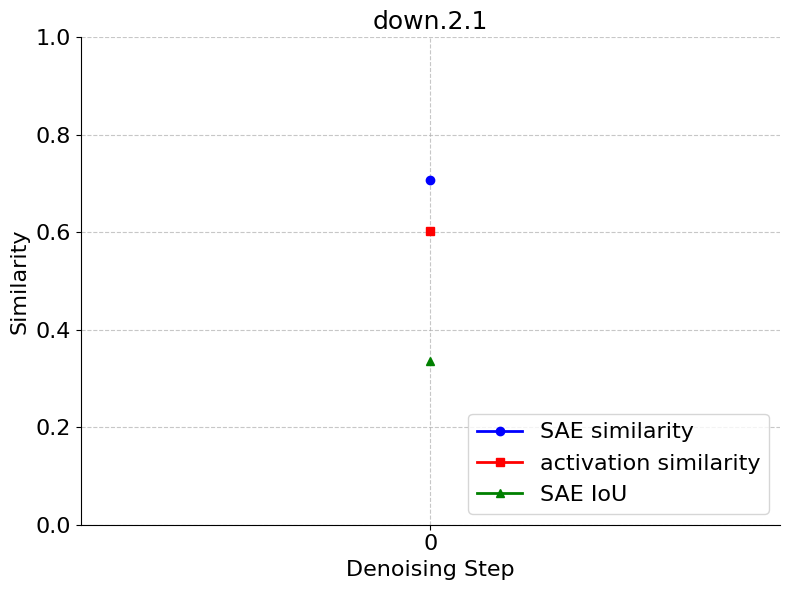

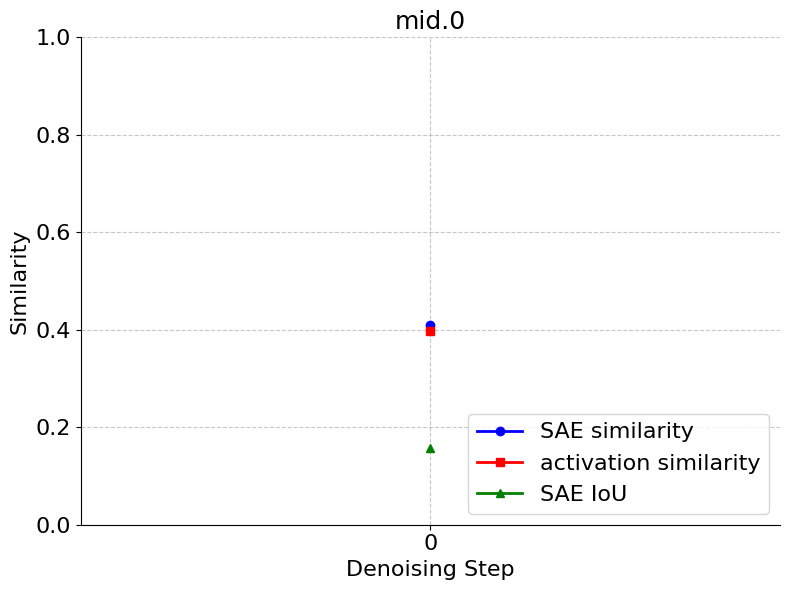

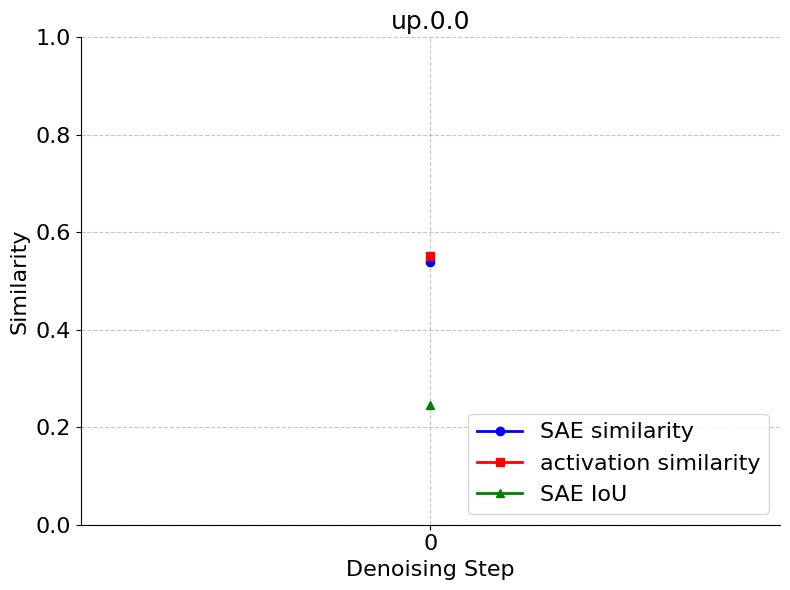

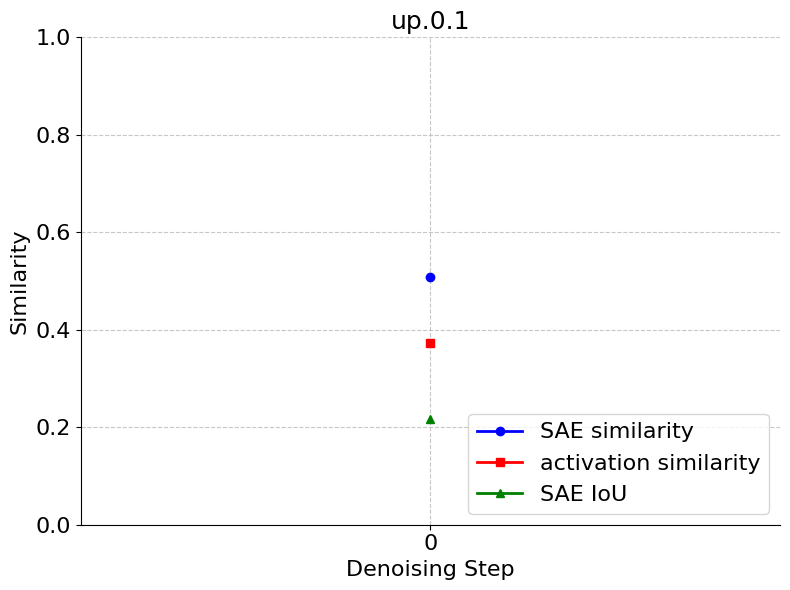

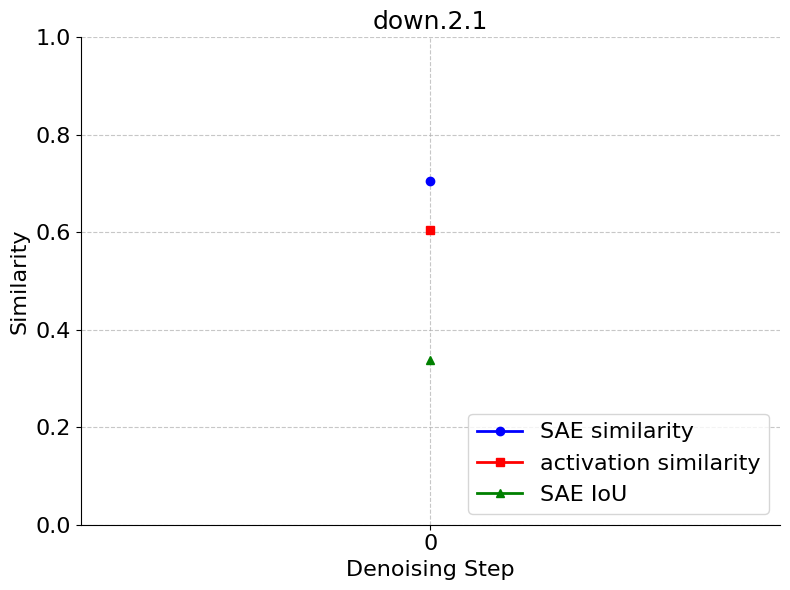

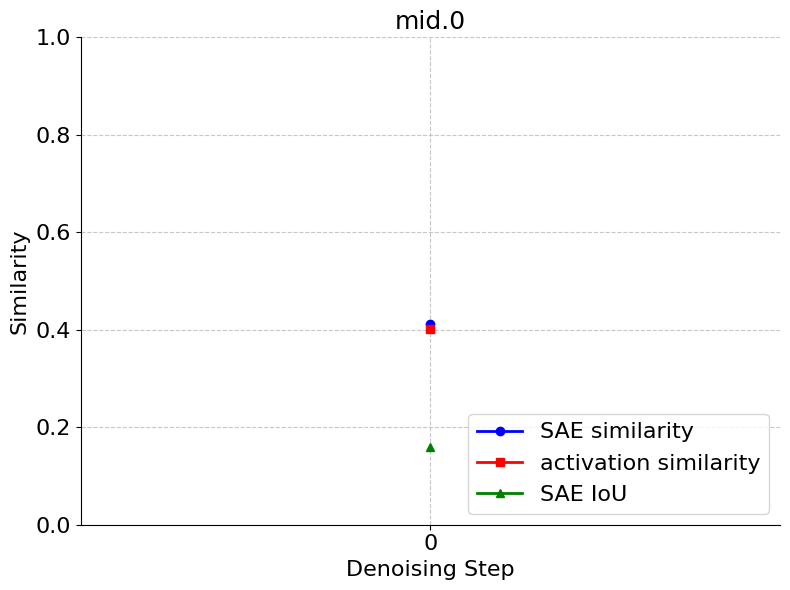

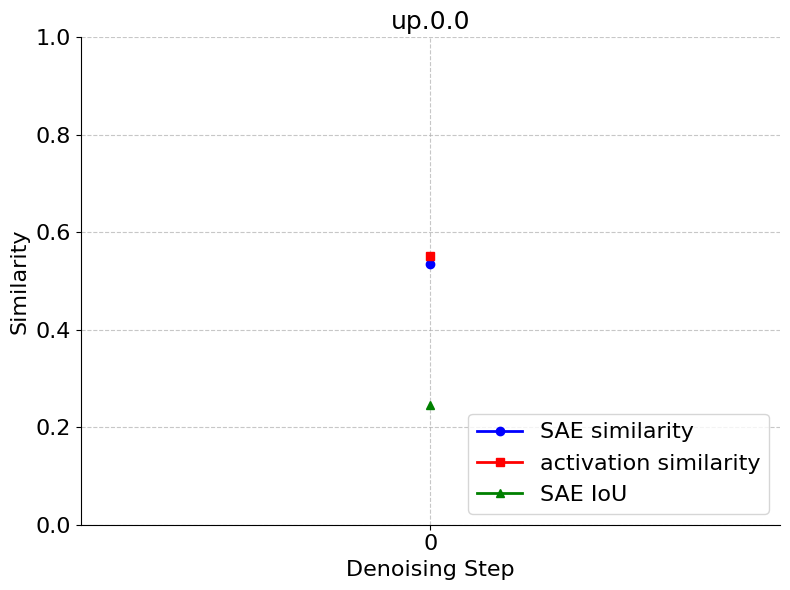

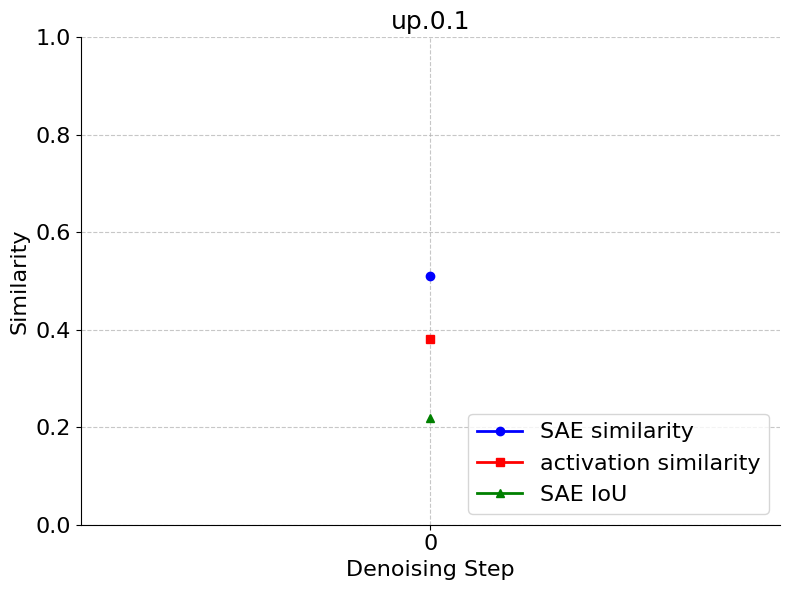

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get unique block names
block_types = sorted(df['block'].unique())

# Get the number of cfg indices
if use_vanilla:
    cfg_indices = [0, 1]  # Assuming we have cfg_idx 0 and 1
else:
    cfg_indices = [0]

for cfg_idx in cfg_indices:
    # Colors for different metrics
    colors = {'fdots': 'blue', 'dots': 'red', 'fdots_binarized': 'green'}
    
    # Set common style parameters
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    
    # Plot each block in a separate figure
    for i, block_type in enumerate(block_types):
        # Create a single figure for this block
        plt.figure(figsize=(8, 6))
            
        # Filter data for this block type and cfg_idx
        block_data = df[df['block'] == block_type]
        
        # Group by tidx to get mean values
        tidx_groups = block_data.groupby('tidx')
        
        # Get unique tidx values and sort them, excluding the last datapoint which is a placeholder
        tidx_values = sorted(block_data['tidx'].unique())[:-1]  # Remove the last tidx (placeholder)
        
        # Get mean and std values for each tidx and metric, excluding the placeholder
        fdots_col = f"fdots_{cfg_idx}"
        dots_col = f"dots_{cfg_idx}"
        fdots_binarized_col = f"iou_{cfg_idx}"
        
        mean_fdots = [tidx_groups.get_group(tidx)[fdots_col].mean() for tidx in tidx_values]
        std_fdots = [tidx_groups.get_group(tidx)[fdots_col].std() / np.sqrt(len(tidx_groups.get_group(tidx))) for tidx in tidx_values]
        
        mean_dots = [tidx_groups.get_group(tidx)[dots_col].mean() for tidx in tidx_values]
        std_dots = [tidx_groups.get_group(tidx)[dots_col].std() / np.sqrt(len(tidx_groups.get_group(tidx))) for tidx in tidx_values]
        
        mean_fdots_binarized = [tidx_groups.get_group(tidx)[fdots_binarized_col].mean() for tidx in tidx_values]
        std_fdots_binarized = [tidx_groups.get_group(tidx)[fdots_binarized_col].std() / np.sqrt(len(tidx_groups.get_group(tidx))) for tidx in tidx_values]
        
        # Plot all three metrics with confidence intervals
        plt.plot(tidx_values, mean_fdots, 'o-', label='SAE similarity', linewidth=2, color=colors['fdots'])
        # Add Gaussian confidence interval: mean ± 1.96*std_error
        plt.fill_between(tidx_values, 
                         [m - 1.96*s for m, s in zip(mean_fdots, std_fdots)], 
                         [m + 1.96*s for m, s in zip(mean_fdots, std_fdots)], 
                         color=colors['fdots'], alpha=0.2)
        
        plt.plot(tidx_values, mean_dots, 's-', label='activation similarity', linewidth=2, color=colors['dots'])
        plt.fill_between(tidx_values, 
                         [m - 1.96*s for m, s in zip(mean_dots, std_dots)], 
                         [m + 1.96*s for m, s in zip(mean_dots, std_dots)], 
                         color=colors['dots'], alpha=0.2)
        
        plt.plot(tidx_values, mean_fdots_binarized, '^-', label='SAE IoU', linewidth=2, color=colors['fdots_binarized'])
        plt.fill_between(tidx_values, 
                         [m - 1.96*s for m, s in zip(mean_fdots_binarized, std_fdots_binarized)], 
                         [m + 1.96*s for m, s in zip(mean_fdots_binarized, std_fdots_binarized)], 
                         color=colors['fdots_binarized'], alpha=0.2)
            
        # Add labels and title
        plt.title(f"{block_type}", fontsize=18)
        plt.xlabel("Denoising Step", fontsize=16)
        plt.ylabel("Similarity", fontsize=16)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Add legend
        plt.legend(fontsize=16, loc='lower right')
            
        plt.tick_params(axis='both', which='major', labelsize=16)
        
        # Set x-ticks to be exactly at the timestep indices
        plt.xticks(tidx_values)
        
        # Set xlim to be 0 and len(timesteps)-2
        plt.xlim(-0.03, len(tidx_values)-1+0.03)
        
        # Set ylim to 0,1
        plt.ylim(0, 1)
        
        plt.tight_layout()
        
        # Save the individual plot
        plt.savefig(f"{outfile.replace('.csv', '')}_{block_type}_similarity_cfg_{cfg_idx}.pdf")
        # also save a png version
        plt.savefig(f"{outfile.replace('.csv', '')}_{block_type}_similarity_cfg_{cfg_idx}.png")
        plt.show()